In [4]:
def convert_dna_string_to_map(input_string):
    dictionary = {}
    key = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i in range (0,26):
        dictionary[key[i]] = input_string[i]
    print(dictionary)

In [5]:
encryptKey = "QWERTYUIOPLKJHGFDSAMNBVCZX"
convert_dna_string_to_map(encryptKey)


{'A': 'Q', 'B': 'W', 'C': 'E', 'D': 'R', 'E': 'T', 'F': 'Y', 'G': 'U', 'H': 'I', 'I': 'O', 'J': 'P', 'K': 'L', 'L': 'K', 'M': 'J', 'N': 'H', 'O': 'G', 'P': 'F', 'Q': 'D', 'R': 'S', 'S': 'A', 'T': 'M', 'U': 'N', 'V': 'B', 'W': 'V', 'X': 'C', 'Y': 'Z', 'Z': 'X'}


In [8]:
### decrypting ciphers with genetic algorithms

# load libraries
import numpy as np
import matplotlib.pyplot as plt

import re
import random
import string
import requests
import os
import textwrap

In [60]:
# create a substitution cipher

# one acts as a key, other as value

letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}
random.shuffle(letters2)

for k,v in zip(letters1, letters2):
    true_mapping[k] = v

In [9]:
### the language model

# Create a markov matrix to represent bigram probabilities, there are 26 * 26 possible bigram combinations
M = np.ones((26,26)) # defined as 1s because of add-one smoothing

# Initial state distribution for each unigram, represents the first letter
pi = np.zeros(26)

# define a function to update the markov matrix
def update_transition(ch1, ch2):
    i = ord(ch1)-97
    j = ord(ch2)-97
    M[i,j]+=1

# define a function to update initial state distribution
def update_pi(ch1):
    i = ord(ch1)-97
    pi[i]+=1

# compute the log probability of a word
def get_word_prob(word):
    i = ord(word[0])-97
    # compute log of count of i
    logp = np.log(pi[i])
    # now compute log prob of bigram combinations for the rest of the word
    for ch in word[1:]:
        j = ord(ch) - 97
        logp += np.log(M[i,j])
        i = j
    return logp

# get the probability of a sequence of words
def get_seq_prob(words):
    # if input is a string, split it into tokens
    if type(words) == str:
        words = words.split()
    # now compute probability by summing up probability of each word
    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

In [11]:
# download file to train
if not os.path.exists('moby_dick.txt'):
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt', 'w') as f:
        f.write(r.content.decode())

In [30]:
# replace non-alpha characters
regex = re.compile("[^a-zA-Z]")

# read the file, strip whitespace, tokenize and update pi and M

for line in open('moby_dick.txt'):
    line = line.rstrip()
    
    if line:
        line = regex.sub(' ', line)
        tokens = line.lower().split()
        
        for token in tokens:
            ch0 = token[0]
            update_pi(ch0)
            
            for ch1 in token[1:]:
                update_transition(ch0,ch1)
                ch0 = ch1
                
# normalize probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [61]:
### message to be encoded

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

#original_message = '''I then lounged down the street and found,
#as I expected, that there was a mews in a lane which runs down
#by one wall of the garden. I lent the ostlers a hand in rubbing
#down their horses, and received in exchange twopence, a glass of
#half-and-half, two fills of shag tobacco, and as much information
#as I could desire about Miss Adler, to say nothing of half a dozen
#other people in the neighbourhood in whom I was not in the least
#interested, but whose biographies I was compelled to listen to.
#'''
original_message = '''Away they went, and I was just wondering whether I should not do well to follow them when up the lane came a neat little landau, the coachman with his coat only half-buttoned, and his tie under his ear, while all the tags of his harness were sticking out of the buckles. It hadn't pulled up before she shot out of the hall door and into it. I only caught a glimpse of her at the moment, but she was a lovely woman, with a face that a man might die for.'''

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [36]:
# write a function to encode and decode text
def encode_message(message):
    message = message.lower()
    regex = re.compile('[^a-zA-Z]')
    message = regex.sub(' ',message)
    
    coded_message = []
    
    for ch in message:
        coded_ch = ch
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
        coded_message.append(coded_ch)
    return ''.join(coded_message)

encoded_message = encode_message(original_message)

# write a function to decode a message
def decode_message(message, word_map):
    decoded_message = []
    for ch in message:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch = word_map[ch]
        decoded_message.append(decoded_ch)
    return ''.join(decoded_message)

In [43]:
# define an evolutionary algorithm to decrypt the message

# define a dna pool that has twenty randomly generated strings
dna_pool = []
for i in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

# define a function to evolve children
def evolve_offspring(dna_pool, n_children):
    off_spring = []
    for dna in dna_pool:
        for n in range (n_children):
            copy = dna.copy()
            i = np.random.randint(len(copy))
            j = np.random.randint(len(copy))
            
            # swap
            temp = copy[i]
            copy[i] = copy[j]
            copy[j] = temp
            
            off_spring.append(copy)
            
    return off_spring + dna_pool            

In [62]:
# genetic algorithm
num_iters = 1200
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
    if i>0:
        dna_pool = evolve_offspring(dna_pool, 3)
        
        # calculate score for each dna
    dna2score = {}
        
    for dna in dna_pool:
        current_map = {}
        for k,v in zip(letters1, dna):
            current_map[k] = v
                
        decoded_message = decode_message(encoded_message, current_map)
        score = get_seq_prob(decoded_message)
            
        dna2score[''.join(dna)] = score
            
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
            
    # average score for this generation        
    scores[i] = np.mean(list(dna2score.values()))
    
    # keep best 5 dna
    # turn them back into list of single chars
    
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]
    
    if i % 200 == 0:
        print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -938.6429617065296 best so far: -938.6429617065296
iter: 200 score: -1241.0824253579256 best so far: -938.6429617065296
iter: 400 score: -1251.1923754042812 best so far: -938.6429617065296
iter: 600 score: -1353.6542694286024 best so far: -938.6429617065296
iter: 800 score: -1306.7251350283743 best so far: -938.6429617065296
iter: 1000 score: -1307.7606415545604 best so far: -938.6429617065296


In [56]:
# evaluate our algorithm

decoded_message = decode_message(encoded_message, best_map)
print("LL of decoded message is: ", get_seq_prob(decoded_message))
print("LL of true message:", get_seq_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message is:  -938.6429617065296
LL of true message: -932.9507586952323
true: b, pred: m
true: j, pred: q
true: k, pred: z
true: m, pred: b
true: p, pred: y
true: q, pred: j
true: y, pred: p
true: z, pred: k


In [57]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i exyected  that there
was a bews in a lane which runs down mp one wall of the garden  i lent
the ostlers a hand in rumming down their horses  and received in
exchange twoyence  a glass of half and half  two fills of shag tomacco
and as buch inforbation as i could desire amout biss adler  to sap
nothing of half a doken other yeoyle in the neighmourhood in whob i
was not in the least interested  mut whose miograyhies i was cobyelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

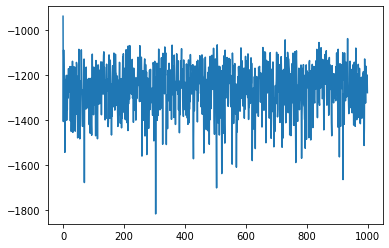

In [58]:
plt.plot(scores)
plt.show()